## 1. **Import Required Libraries**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

## 2. **Get Data**

### 2.1 **Load datasets**

In [2]:
# Load application record and credit record data into DataFrames
cc_application_df = pd.read_csv('data/application_record.csv')
cc_status_df = pd.read_csv('data/credit_record.csv')

### 2.2. **Create target variable**

In [3]:
# Determine how long each person has held their credit card
cc_duration = cc_status_df.groupby("ID")["MONTHS_BALANCE"].min().reset_index().rename(columns={"MONTHS_BALANCE": "months_hold_cc"})
cc_application_df = pd.merge(cc_application_df, cc_duration, how="left", on="ID")

# Create a new column 'is_risky' that identifies if the STATUS is considered risky (values 2, 3, 4, or 5)
cc_status_df['is_risky'] = np.where(cc_status_df['STATUS'].isin(['2', '3', '4', '5']), 'Yes', 'No')

# Determine if a person has ever defaulted, with Yes mapped to 1 and No mapped to 0
cc_defaulter = cc_status_df.groupby('ID')['is_risky'].max().reset_index()
cc_defaulter['is_risky'] = cc_defaulter['is_risky'].map({'Yes': 1, 'No': 0})
cc_application_df = pd.merge(cc_application_df, cc_defaulter, how='inner', on='ID')

# Ensure duration is positive and convert it to integer type for consistent data handling
cc_application_df['months_hold_cc'] = np.abs(cc_application_df['months_hold_cc']).astype('int64')

### 2.3 **Rename features**

In [4]:
# Define a mapping to rename DataFrame columns for clarity and consistency
column_rename_map = {
    'CODE_GENDER': 'gender',
    'FLAG_OWN_CAR': 'owns_car',
    'FLAG_OWN_REALTY': 'owns_property',
    'CNT_CHILDREN': 'child_count',
    'AMT_INCOME_TOTAL': 'annual_income',
    'NAME_INCOME_TYPE': 'work_type',
    'NAME_EDUCATION_TYPE': 'education',
    'NAME_FAMILY_STATUS': 'marital_status',
    'NAME_HOUSING_TYPE': 'accommodation',
    'DAYS_BIRTH': 'days_lived',
    'DAYS_EMPLOYED': 'days_employed',
    'FLAG_MOBIL': 'has_mobile',
    'FLAG_WORK_PHONE': 'has_work_phone',
    'FLAG_PHONE': 'has_phone',
    'FLAG_EMAIL': 'has_email',
    'OCCUPATION_TYPE': 'profession',
    'CNT_FAM_MEMBERS': 'family_size'
}
cc_application_df.rename(columns=column_rename_map, inplace=True)

### 2.4. **Split data**

In [5]:
# DataFrame before splitting data
final_df = cc_application_df.drop(columns=['ID'])

# Split the data into train and test sets
def data_split(df, size):
    train_df, test_df = train_test_split(df, test_size=size, random_state=42)
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

cc_train_original, cc_test_original = data_split(final_df, 0.2)

## 3. **Exploratory Data Analysis (EDA)**

In [6]:
# creating a copy of the dataset so that the original stays untouched
cc_train_copy = cc_train_original.copy()
cc_test_copy = cc_test_original.copy()

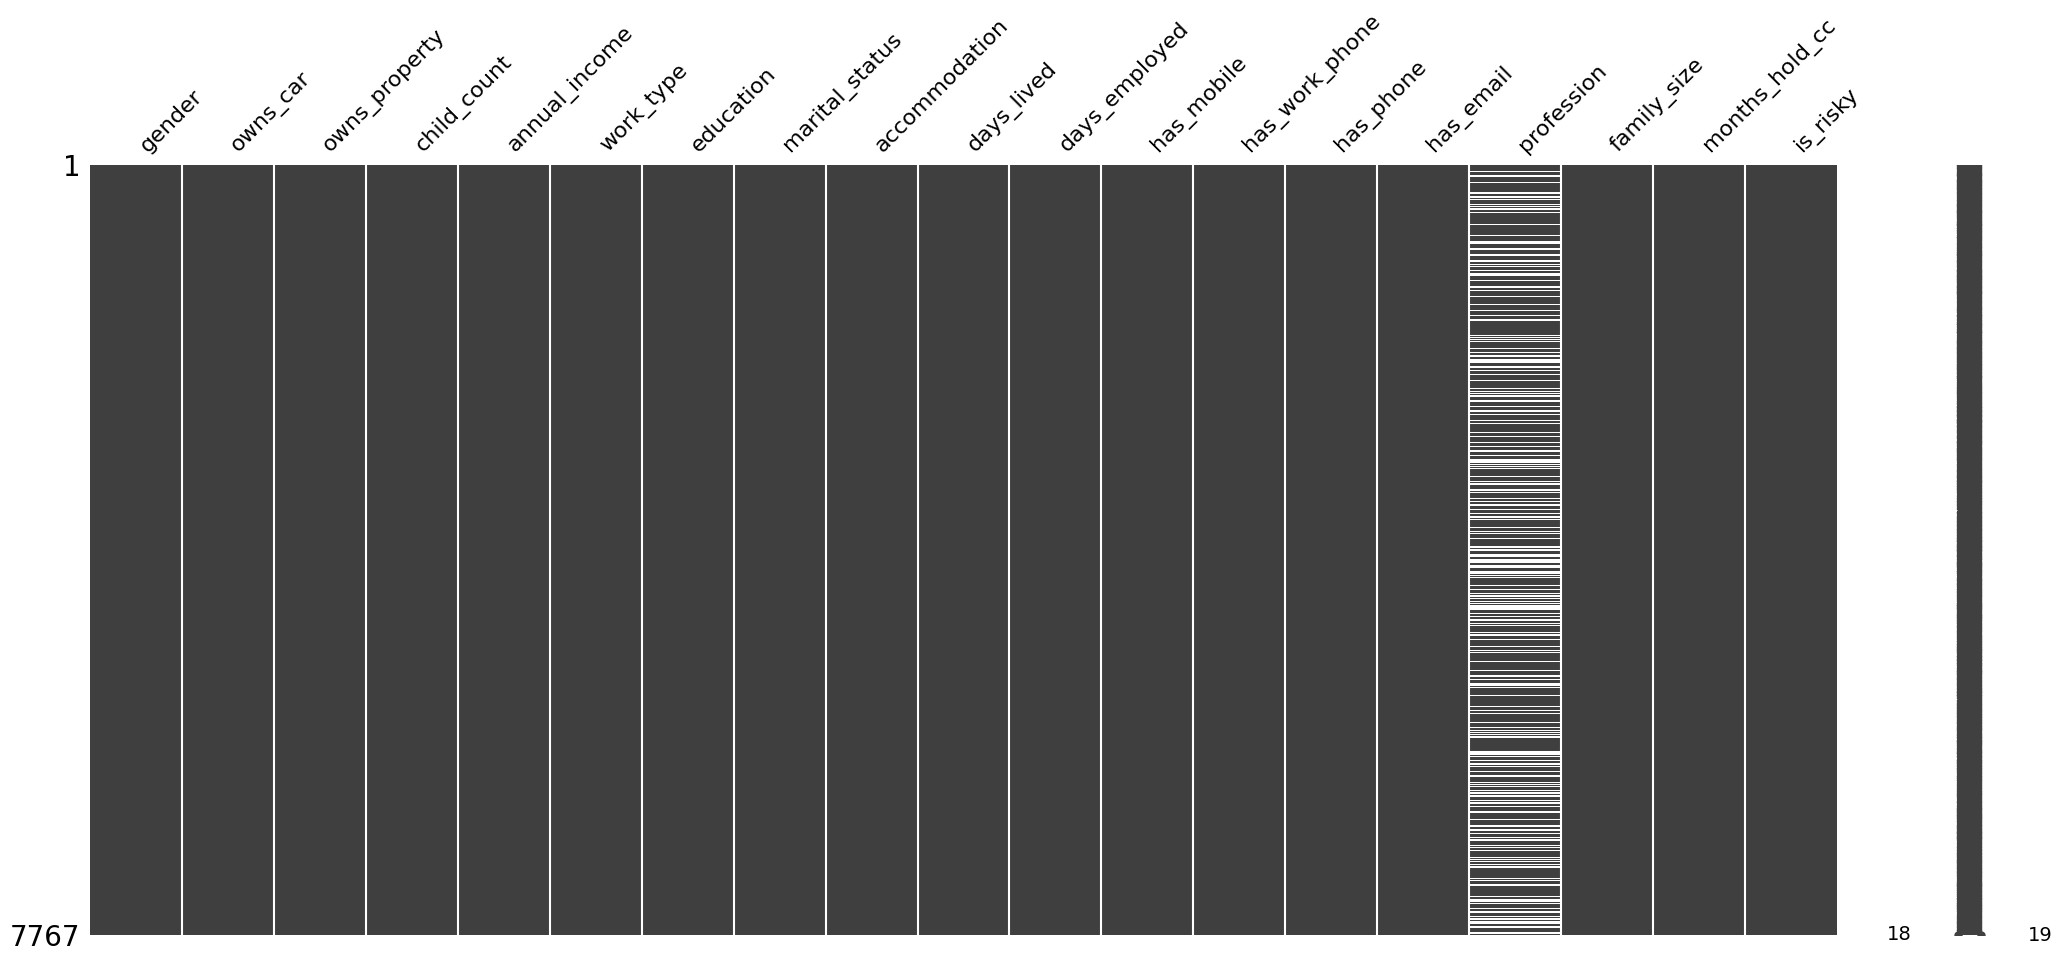

In [7]:
msno.matrix(cc_train_copy)
plt.show()

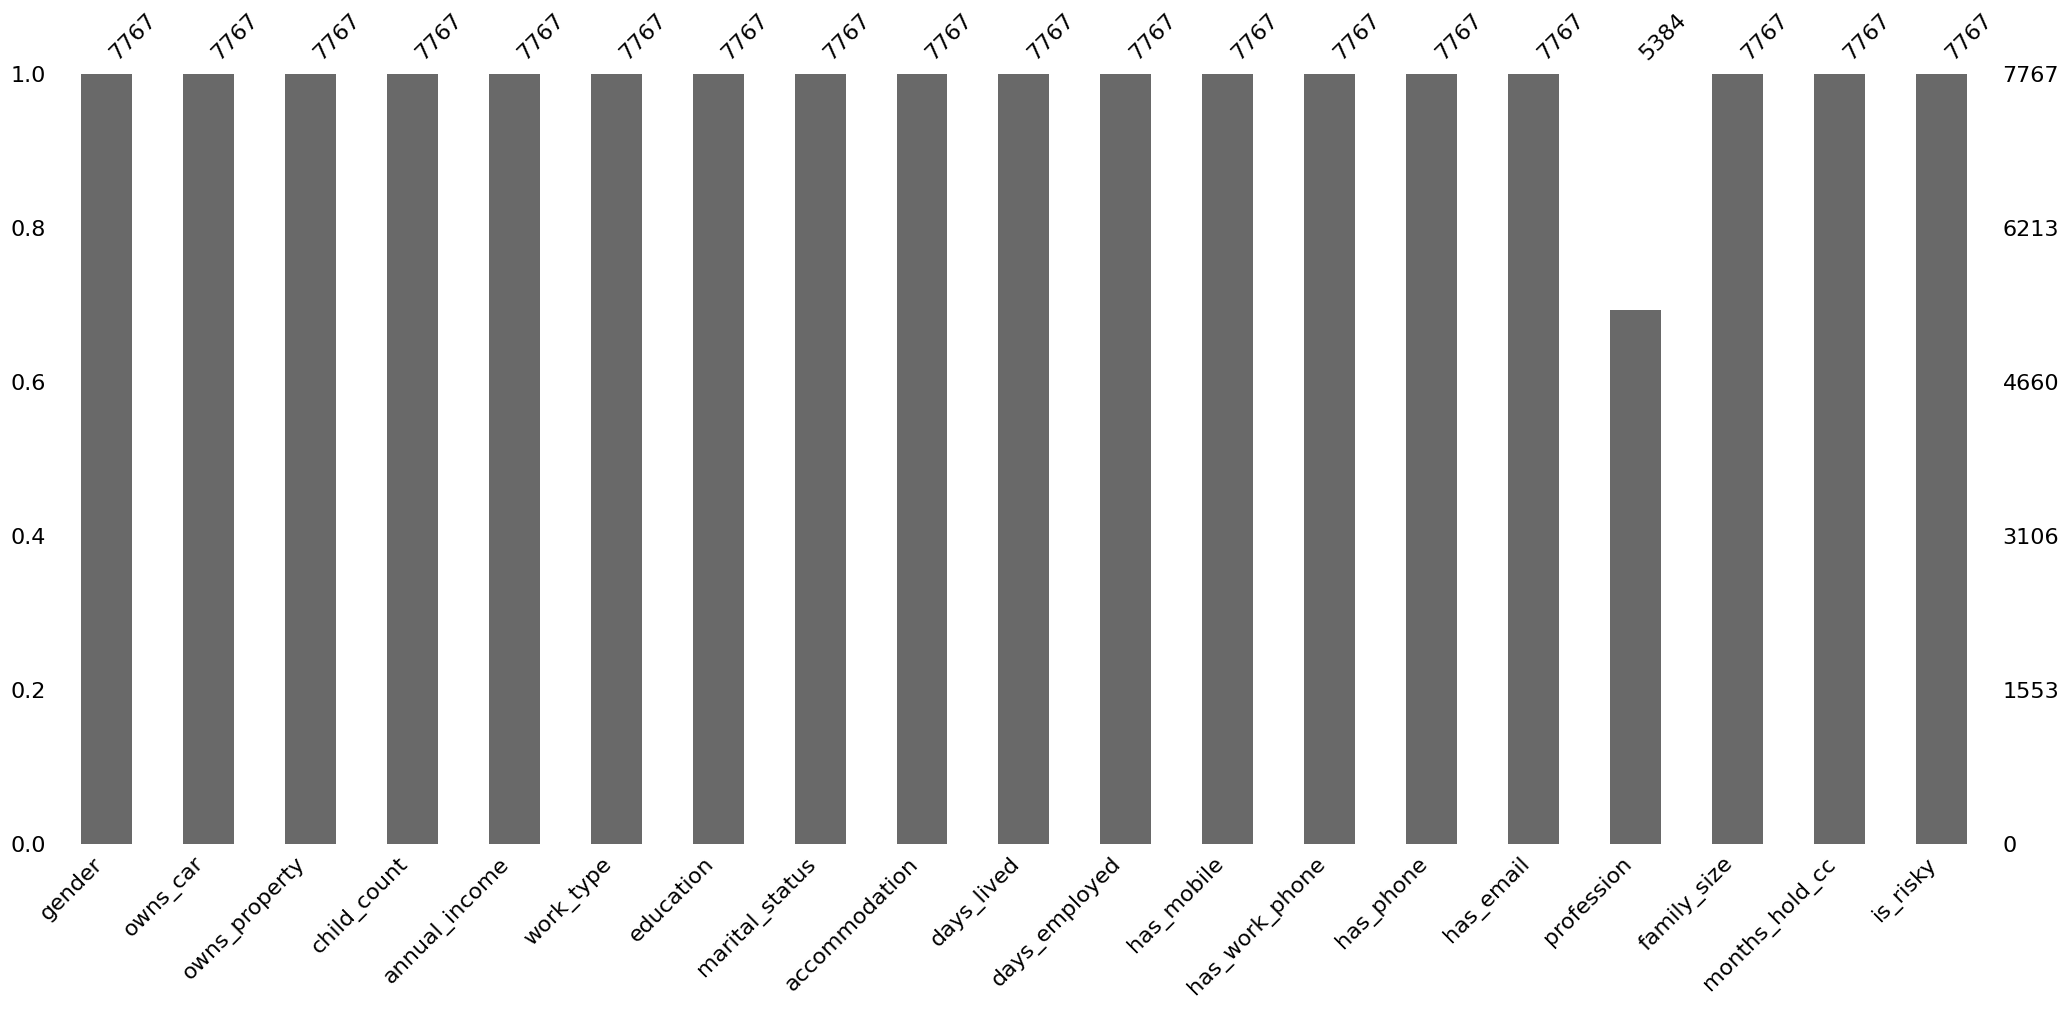

In [8]:
msno.bar(cc_train_copy)
plt.show()

In [9]:
#Function that will return the count and frequency of each observation within a feature
def count_and_freq_stats(df,feature):
    ftr_value_cnt = df[feature].value_counts()
    ftr_value_cnt_norm = df[feature].value_counts(normalize=True) * 100
    ftr_value_cnt_concat = pd.concat([ftr_value_cnt, ftr_value_cnt_norm], axis=1)
    ftr_value_cnt_concat.columns = ['Count', 'Frequency']
    return ftr_value_cnt_concat

### 3.1 **Gender**

In [10]:
cc_train_copy['gender'].describe()

count     7767
unique       2
top          F
freq      5029
Name: gender, dtype: object

In [11]:
# Perform gender count and frequency analysis using the helper function
gender_stats = count_and_freq_stats(cc_train_copy, 'gender')

# Extract data for plotting
gender_counts = gender_stats['Count']
gender_freqs = gender_stats['Frequency']

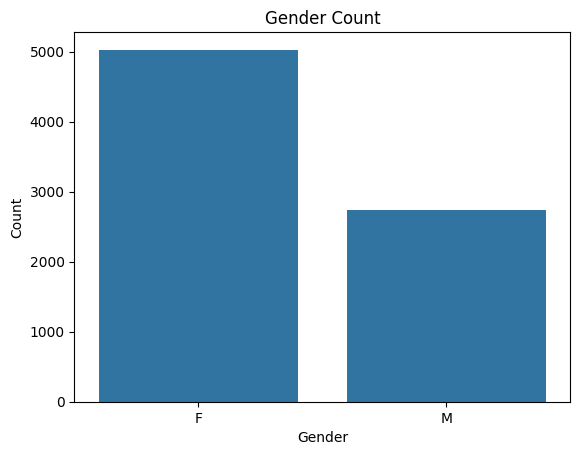

In [12]:
# Plot bar chart for gender counts
sns.barplot(x=gender_counts.index, y=gender_counts.values)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Gender Count')
plt.show()

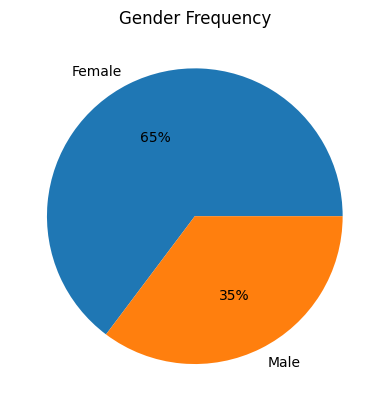

In [13]:
# Plot pie chart for gender distribution (frequency)
plt.pie(gender_freqs, labels=['Female','Male'], autopct='%1.0f%%')
plt.title('Gender Frequency')
plt.show()

### 3.2 **Age**

In [14]:
# Convert age from days to years, accounting for leap years
cc_train_copy['days_lived'] = np.abs(cc_train_copy['days_lived'])/365.25
cc_train_copy['days_lived'].describe()

count    7767.000000
mean       43.822532
std        11.593486
min        21.095140
25%        34.083504
50%        42.787132
75%        53.564682
max        68.862423
Name: days_lived, dtype: float64

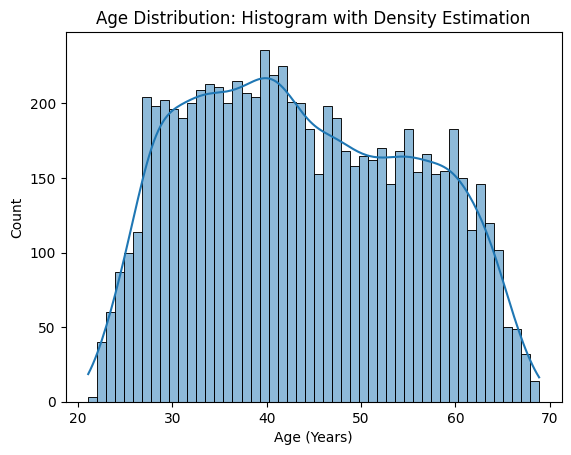

In [15]:
# Histogram for age distribution with KDE
sns.histplot(cc_train_copy['days_lived'], bins=50, kde=True)
plt.title('Age Distribution: Histogram with Density Estimation')
plt.xlabel('Age (Years)')
plt.show()

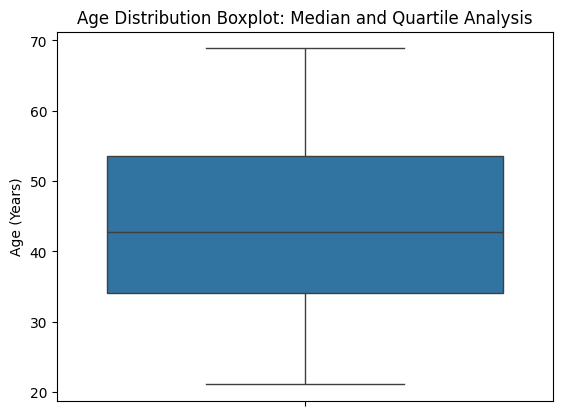

In [16]:
# Boxplot illustrating age distribution, including median, quartiles, and outliers
sns.boxplot(y=cc_train_copy['days_lived'])
plt.title('Age Distribution Boxplot: Median and Quartile Analysis')
plt.ylabel('Age (Years)')
plt.show()

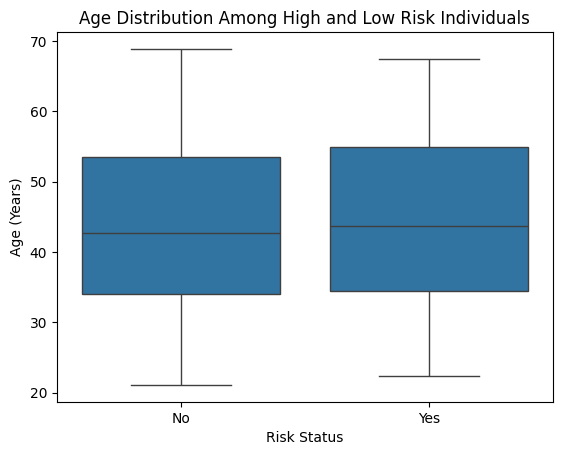

In [17]:
# Boxplot for age grouped by risk status
sns.boxplot(x=cc_train_copy["is_risky"], y=cc_train_copy['days_lived'])
plt.xticks(ticks=[0, 1], labels=["No", "Yes"])
plt.title('Age Distribution Among High and Low Risk Individuals')
plt.xlabel('Risk Status')
plt.ylabel('Age (Years)')
plt.show()